# Import

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install transformers
!pip install tf-models-official

In [6]:
# for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# for w2v
import gensim
import gensim.downloader as gensim_api

# for processing
import re
import nltk

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for BERT
import transformers
import os
import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from torchvision.transforms import ToTensor

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
# !python -c "import torch; print(torch.__version__)"
# !python -c "import torch; print(torch.version.cuda)"

In [9]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
# !pip install torch-geometric

# Data obrabotka

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
!cp /content/gdrive/MyDrive/Cora_data/cora_new.csv /content
!cp /content/gdrive/MyDrive/Cora_data/df_lst_mean_vecs.csv /content
!cp /content/gdrive/MyDrive/Cora_data/classifications.csv /content

In [19]:
df = pd.read_csv('cora_new.csv')

In [20]:
# I've taken this function from guthub: 
# https://github.com/LaurentVeyssier/Unsupervised-text-classification-with-BERT-embeddings/blob/main/unsupervised_text_classification_with_BERT

def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
  
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # back to string from list
    return text

In [21]:
df.fillna('')

,Title,Abstract
0,Spherical Wavelets: Texture Processing,Wavelets are a powerful tool for planar image ...
1,Running dynamic programming algorithms on a DN...,In this paper we show that DNA computers are e...
2,Chapter 5 Multivalue or Multistep Methods 5.1 ...,One-step methods only require information abou...
3,How to Create and Animate a Dancing Dinosaur w...,In this short paper we present a case study of...
4,Growing neural networks,
...,...,...
52834,AN ANALYTICAL DELAY MODEL FOR RLC INTERCONNECTS,We develop an analytical delay model based on ...
52835,Adaptive Rate-Controlled Scheduling for Multim...,We present a framework for integrated scheduli...
52836,Reasoning about Continuous Change,The problem of formalising continuous change w...
52837,Conjunctive Query Equivalence of Keyed Relatio...,An abbreviated version of this paper is to app...


In [22]:
df['Title_clean'] = df['Title'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True))
df['Abstract_clean'] = df['Abstract'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True))
df = df.drop(['Title', 'Abstract'], axis=1)
df.head(3)

,Title_clean,Abstract_clean
0,spherical wavelets texture processing,wavelets are a powerful tool for planar image ...
1,running dynamic programming algorithms on a dn...,in this paper we show that dna computers are e...
2,chapter 5 multivalue or multistep methods 51 i...,onestep methods only require information about...


In [23]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [24]:
# Remove end spaces
def remove_end_spaces(string):
    return "".join(string.rstrip())

# Remove first and  end spaces
def remove_first_end_spaces(string):
    return "".join(string.rstrip().lstrip())

In [25]:
df1 = pd.read_csv('/content/classifications.csv', sep = '\s+', on_bad_lines='skip')
df2 = df1['/Information_Retrieval/Retrieval/']
list_classes = []
for row in df2:
  list_classes.append(row)
list_classes = list(set(list_classes))

list_words = set()
for i in range(len(list_classes)):
  list_classes[i] = list_classes[i].replace('/', ' ')
  list_classes[i] = list_classes[i].replace('__', ' ')
  list_classes[i] = list_classes[i].replace('_', ' ')
  remove_end_spaces(list_classes[i])
  remove_first_end_spaces(list_classes[i])

set(list_classes)
for sub_l in list_classes:
    list_words.update(sub_l.split())

set(list_classes)

{' Artificial Intelligence Agents ',
 ' Artificial Intelligence Data Mining ',
 ' Artificial Intelligence Expert Systems ',
 ' Artificial Intelligence Games and Search ',
 ' Artificial Intelligence Knowledge Representation ',
 ' Artificial Intelligence Machine Learning Case-Based ',
 ' Artificial Intelligence Machine Learning Genetic Algorithms ',
 ' Artificial Intelligence Machine Learning Neural Networks ',
 ' Artificial Intelligence Machine Learning Probabilistic Methods ',
 ' Artificial Intelligence Machine Learning Reinforcement Learning ',
 ' Artificial Intelligence Machine Learning Rule Learning ',
 ' Artificial Intelligence Machine Learning Theory ',
 ' Artificial Intelligence NLP ',
 ' Artificial Intelligence Planning ',
 ' Artificial Intelligence Robotics ',
 ' Artificial Intelligence Speech ',
 ' Artificial Intelligence Theorem Proving ',
 ' Artificial Intelligence Vision and Pattern Recognition ',
 ' Data Structures Algorithms and Theory Computational Complexity ',
 ' Data 

In [26]:
df1 = df1.replace(['/Information_Retrieval/Digital_Library/',
 '/Information_Retrieval/Extraction/',
 '/Information_Retrieval/Filtering/',
 '/Information_Retrieval/Retrieval/'], 'information retrieval') 
df1 = df1.replace(['/Artificial_Intelligence/Agents/','/Artificial_Intelligence/Data_Mining/','/Artificial_Intelligence/Expert_Systems/','/Artificial_Intelligence/Games_and_Search/','/Artificial_Intelligence/Knowledge_Representation/',
                   '/Artificial_Intelligence/Machine_Learning/Case-Based/','/Artificial_Intelligence/Machine_Learning/Genetic_Algorithms/','/Artificial_Intelligence/Machine_Learning/Neural_Networks/','/Artificial_Intelligence/Machine_Learning/Probabilistic_Methods/',
                   '/Artificial_Intelligence/Machine_Learning/Reinforcement_Learning/','/Artificial_Intelligence/Machine_Learning/Rule_Learning/','/Artificial_Intelligence/Machine_Learning/Theory/','/Artificial_Intelligence/NLP/','/Artificial_Intelligence/Planning/',
                   '/Artificial_Intelligence/Robotics/','/Artificial_Intelligence/Speech/','/Artificial_Intelligence/Theorem_Proving/','/Artificial_Intelligence/Vision_and_Pattern_Recognition/'], 'Artificial Intelligence') 
df1 = df1.replace(['/Data_Structures__Algorithms_and_Theory/Computational_Complexity/','/Data_Structures__Algorithms_and_Theory/Computational_Geometry/','/Data_Structures__Algorithms_and_Theory/Formal_Languages/','/Data_Structures__Algorithms_and_Theory/Hashing/',
                   '/Data_Structures__Algorithms_and_Theory/Logic/','/Data_Structures__Algorithms_and_Theory/Parallel/','/Data_Structures__Algorithms_and_Theory/Quantum_Computing/','/Data_Structures__Algorithms_and_Theory/Randomized/',
                   '/Data_Structures__Algorithms_and_Theory/Sorting/'], 'data structures algorithms and theory') 
df1 = df1.replace(['/Databases/Concurrency/','/Databases/Deductive/','/Databases/Object_Oriented/','/Databases/Performance/','/Databases/Query_Evaluation/','/Databases/Relational/','/Databases/Temporal/'],
                  'databases') 
df1 = df1.replace(['/Encryption_and_Compression/Compression/','/Encryption_and_Compression/Encryption/','/Encryption_and_Compression/Security/'],
                  'encryption and compression') 
df1 = df1.replace(['/Hardware_and_Architecture/Distributed_Architectures/','/Hardware_and_Architecture/High_Performance_Computing/','/Hardware_and_Architecture/Input_Output_and_Storage/','/Hardware_and_Architecture/Logic_Design/','/Hardware_and_Architecture/Memory_Structures/',
                   '/Hardware_and_Architecture/Microprogramming/','/Hardware_and_Architecture/VLSI/'], 
                  'hardware and architecture') 
df1 = df1.replace(['/Human_Computer_Interaction/Cooperative/','/Human_Computer_Interaction/Graphics_and_Virtual_Reality/','/Human_Computer_Interaction/Interface_Design/',
                   '/Human_Computer_Interaction/Multimedia/','/Human_Computer_Interaction/Wearable_Computers/'], 
                  'human computer interaction') 
df1 = df1.replace(['/Networking/Internet/','/Networking/Protocols/','/Networking/Routing/','/Networking/Wireless/'], 
                  'networking') 
df1 = df1.replace(['/Operating_Systems/Distributed/','/Operating_Systems/Fault_Tolerance/','/Operating_Systems/Memory_Management/','/Operating_Systems/Realtime/'],
                  'operating systems') 
df1 = df1.replace(['/Programming/Compiler_Design/','/Programming/Debugging/','/Programming/Functional/','/Programming/Garbage_Collection/','/Programming/Java/','/Programming/Logic/','/Programming/Object_Oriented/','/Programming/Semantics/',
                   '/Programming/Software_Development/'], 
                  'programming') 

In [27]:
len(set(df1['/Information_Retrieval/Retrieval/'].values))

10

In [28]:
dict_list1 = ['agents','data', 'mining','expert', 'systems','games', 'search','knowledge', 'representation','machine','machine', 'learning', 'genetic', 'algorithms','machine', 'learning', 'neural', 'networks','machine', 
                                                     'learning', 'probabilistic', 'methods','machine', 'learning', 'reinforcement', 'learning',
                                                    'machine', 'learning', 'rule', 'learning','machine', 'learning', 'theory','nlp','planning','robotics','speech','theorem', 'proving','vision', 'and', 'pattern', 'recognition']
dict_list2 = ['computational', 'complexity','computational', 'geometry','formal', 'languages','hashing','logic','parallel','quantum', 'computing','randomized','sorting']
dict_list3 = ['concurrency','deductive','object', 'oriented','performance','query', 'evaluation','relational','temporal']
dict_list4 = ['compression','encryption','security']
dict_list5 = ['distributed', 'architectures','high', 'performance', 'computing','input', 'output', 'and', 'storage','logic', 'design','memory', 'structures','vlsi']
dict_list6 = ['cooperative','graphics', 'and', 'virtual', 'reality','interface', 'design','multimedia','wearable', 'computers']
dict_list7 = ['digital', 'library','extraction','filtering','retrieval']
dict_list8 = ['internet','protocols','routing','wireless']
dict_list9 = ['distributed','fault', 'tolerance','memory', 'management','realtime','programming', 'compiler', 'design']
dict_list10 = ['compiler', 'design','debugging','functional','garbage', 'collection','java','logic','object', 'oriented','software', 'development']

In [29]:
dict_list1 = list(set(dict_list1))
dict_list2 = list(set(dict_list2))
dict_list3 = list(set(dict_list3))
dict_list4 = list(set(dict_list4))
dict_list5 = list(set(dict_list5))
dict_list6 = list(set(dict_list6))
dict_list7 = list(set(dict_list7))
dict_list8 = list(set(dict_list8))
dict_list9 = list(set(dict_list9))
dict_list10 = list(set(dict_list10))

In [30]:
dictionary_of_classes = {'Artificial Intelligence': dict_list1,
                         'data structures algorithms and theory': dict_list2,
                         'databases': dict_list3,
                         'encryption and compression': dict_list4,
                         'hardware and architecture': dict_list5,
                         'human computer interaction': dict_list6,
                         'information retrieval':dict_list7,
                         'networking': dict_list8,
                         'operating systems': dict_list9,
                         'programming': dict_list10
                         }

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(df['Abstract_clean'], df['Title_clean'], test_size=0.2, random_state=25)
# X_train = np.array([np.array(val) for val in X_train])
# y_train = np.array([np.array(val) for val in y_train])
# X_test = np.array([np.array(val) for val in X_test])
# y_test = np.array([np.array(val) for val in y_test])

**Data set is prepared** </br>
**Going to BERT setup and futher experiment**

## Creating target clusters

In [32]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [33]:
for key in dictionary_of_classes:
  dictionary_of_classes[key] = get_similar_words(dictionary_of_classes[key], top=10, nlp=nlp)

In [34]:
# 5 closest words
print('Top words per label:')
for k,v in dictionary_of_classes.items():
    print("{0:15}..... {1}".format(k, v[0:5], len(v)))

Top words per label:
Artificial Intelligence..... ['machine', 'method', 'particular', 'neural', 'learning']
data structures algorithms and theory..... ['languages', 'geometry', 'computing', 'randomized', 'algorithm']
databases      ..... ['deductive', 'algorithms', 'analysis', 'performance', 'function']
encryption and compression..... ['authentication', 'security', 'encrypted', 'software', 'encryption']
hardware and architecture..... ['applications', 'computing', 'hardware', 'systems', 'vlsi']
human computer interaction..... ['computing', 'video', 'hardware', 'user', 'technology']
information retrieval..... ['database', 'archive', 'archiving', 'extraction', 'filtering']
networking     ..... ['voip', 'users', 'protocol', 'messaging', 'networks']
operating systems..... ['application', 'management', 'computing', 'programming', 'realtime']
programming    ..... ['application', 'development', 'hardware', 'tool', 'collection']


### Vizualization

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


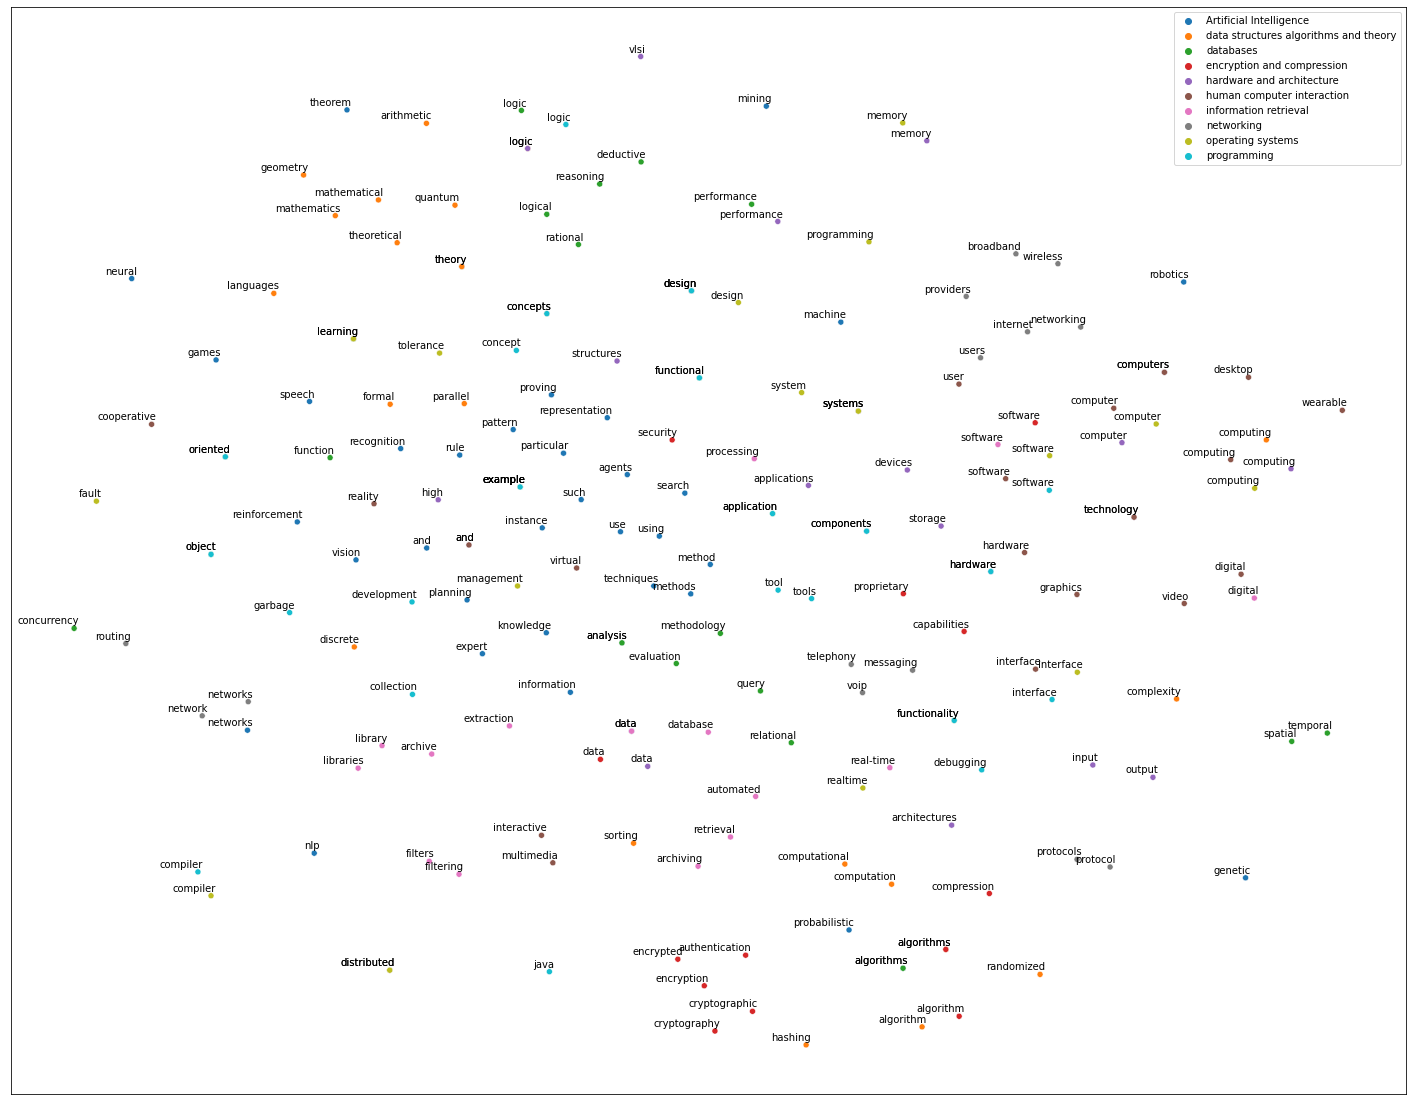

In [35]:
## word embedding
tot_words = [word for v in dictionary_of_classes.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

df_GloVe = pd.DataFrame()
for k,v in dictionary_of_classes.items():
    size = len(df_GloVe) + len(v)
    dtf_group = pd.DataFrame(X[len(df_GloVe):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    df_GloVe = df_GloVe.append(dtf_group)
        
# plot
fig, ax = plt.subplots(figsize=(25,20))
sns.scatterplot(data=df_GloVe, x="x", y="y", hue="cluster", ax=ax)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(df_GloVe)):
    ax.annotate(df_GloVe.index[i], xy=(df_GloVe["x"].iloc[i], df_GloVe["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

# Experiment

In [36]:
# tokenizer using "usual" BERT (bert-base-uncased)
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#Bert itself loaded to nlp variable
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [37]:
def bert_embedding(txt, tokenizer, nlp):
    # sentence to (integers)
    tmp_encoder = tokenizer.encode(txt)
    # to numpy array with shape (1, <EOS> + n_words + <CLS>)
    tmp_encoder = np.array(tmp_encoder)[None,:]
    embedding = nlp(tmp_encoder)
    # for 1st member of the tuple: remove 1st dimension (i.e. result is going to be (n_words, 712))
    # delete CLS & EOS
    embedding1 = np.array(embedding[0][0][1:-1])
    return embedding1

In [38]:
#list of abstracts vectors
lst_mean_vecs = [bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df['Abstract_clean'])]

  0%|          | 37/52839 [00:06<2:29:17,  5.89it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100%|██████████| 52839/52839 [2:23:58<00:00,  6.12it/s]


In [172]:
# lst_mean_vecs = pd.read_csv('/content/df_lst_mean_vecs.csv')
# lst_mean_vecs = lst_mean_vecs.drop(['Unnamed: 0'], axis=1)
# lst_mean_vecs = lst_mean_vecs.dropna()

In [173]:
# lst_mean_vecs = lst_mean_vecs.values.tolist()

In [174]:
# df_lst_mean_vecs = pd.DataFrame(lst_mean_vecs)
# df_lst_mean_vecs.to_csv('/content/df_lst_mean_vecs.csv')

In [39]:
# feature matrix (n_articles x 768)
X = np.array(lst_mean_vecs)
X.shape

(52839, 768)

In [62]:
X_new = np.array(lst_mean_vecs[0:30786])

In [63]:
X_new.shape

(30786, 768)

In [64]:
X = X_new

In [65]:
dic_y = {k:bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dictionary_of_classes.items())}

100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


In [66]:
def fix_NAN_inf_values(x):
    '''Replace NaN with zero and infinity with large finite numbers'''
    if len(np.where(np.isnan(X))[0])>0 or len(np.where(np.isnan(X))[1])>0:
        return np.nan_to_num(X)

In [67]:
#I use here cosine_similarity
# (n_articles x n_labels(i.e. 10)) Row are containig abstract and similarity score.
similarities = np.array([metrics.pairwise.cosine_similarity(fix_NAN_inf_values(X), y.reshape(1,-1)).T.tolist()[0] for y in dic_y.values()]).T
print(similarities.shape)

# adjusting & rescaling
labels = list(dic_y.keys())
for i in range(len(similarities)):
    # if no similarity found
    if sum(similarities[i]) == 0:
        similarities[i] = [0]*len(labels)
        similarities[i][np.random.choice(range(len(labels)))] = 1
    # rescaling
    similarities[i] = similarities[i] / sum(similarities[i])

# label goes to the highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

(30786, 10)


In [68]:
y_test.shape

(30786,)

In [69]:
predicted_prob.shape

(30786, 10)

Accuracy: 0.26
Auc: 0.5
Detail:
                                       precision    recall  f1-score   support

              Artificial Intelligence       0.38      0.63      0.48     11754
data structures algorithms and theory       0.08      0.00      0.00      3364
                            databases       0.01      0.00      0.00      1356
           encryption and compression       0.04      0.24      0.07      1306
            hardware and architecture       0.04      0.06      0.05      1328
           human computer interaction       0.12      0.01      0.01      1861
                information retrieval       0.09      0.01      0.02       633
                           networking       0.04      0.00      0.00      1771
                    operating systems       0.09      0.02      0.04      2961
                          programming       0.14      0.02      0.03      4452

                             accuracy                           0.26     30786
                  

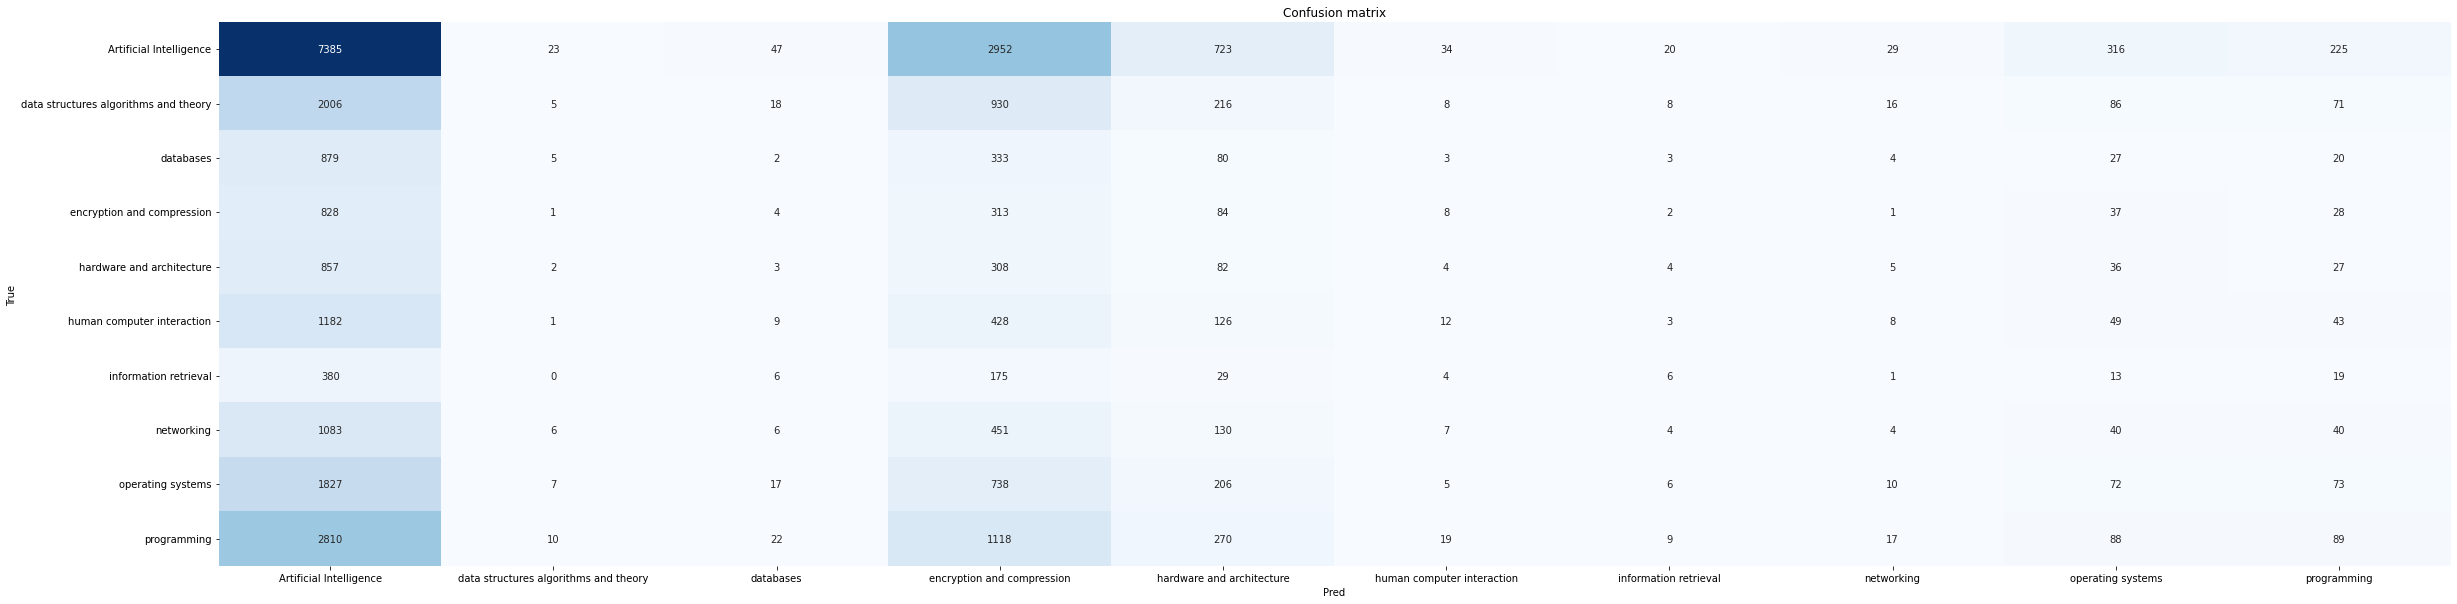

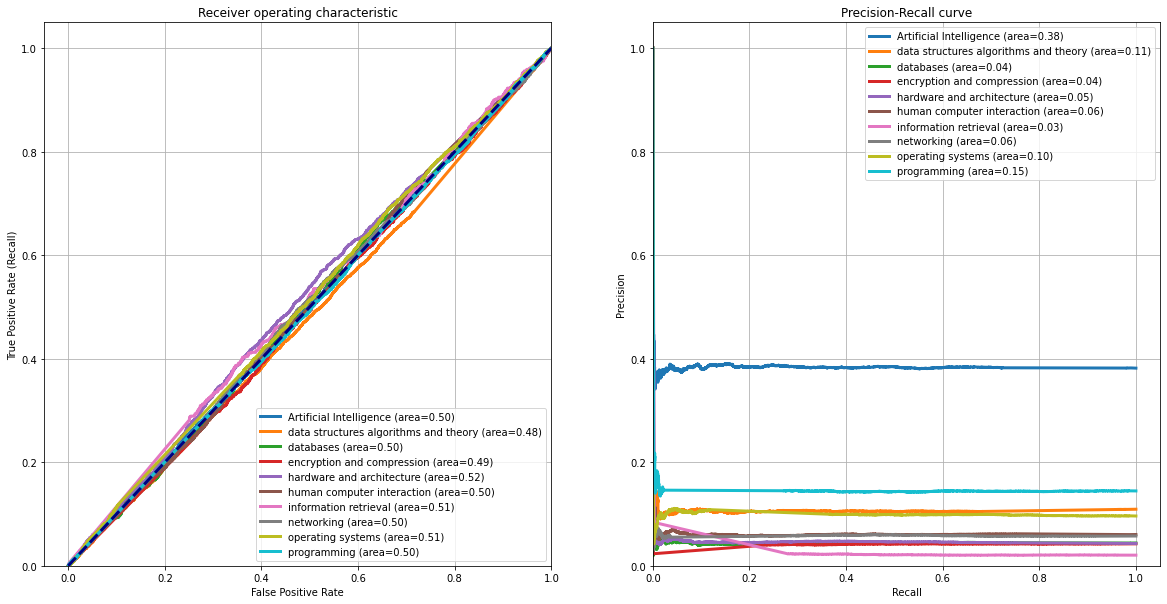

In [70]:
y_test = df1['/Information_Retrieval/Retrieval/'].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots(figsize=(40,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
# Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3,  label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [71]:
## Вообщем классифицируется из рук вон плохо))) но работает и создает кластеры, наверно результат был мог бы быть лучше если бы я аккуратнее работал с датой и не выкидывал любые проблемные места, в целом